Install Libraries

In [ ]:
!pip install imbalanced-learn

Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import imblearn

Import Dataset

In [3]:
df = pd.read_csv('dataset.csv')
df.head(1)

,word_id,sentence_id,word,label,is_ne,is_spelling_correct
0,45,1,Gusto,FIL,NaN,True


In [ ]:
df.describe()
df.info()

In [4]:
def drop_null_words(df: pd.DataFrame) -> pd.DataFrame:
    df_cleaned = df.dropna(subset=['word'])
    df_cleaned = df_cleaned.reset_index(drop=True)
    return df_cleaned

df = drop_null_words(df)

Feature Engineering / Preprocessing:

Target Features:
 - Word length
 - Vowel / Word Ratio
 - Consonant / Word Ratio
 - Look at common letters not present in filipino word (c, x, z, f, etc.)
 - Common NGram counts for Filipino and English words
    - ng
    - ch, sh, etc.
    - Filipino prefixes (um, in, etc.)
-  Check if the word is a (noun, verb, etc based on the sentence)

More features helping English prediction


Note: normalize data if needed (check sklearn.preprocessing)

In [ ]:
len(df["is_spelling_correct"])

Length Feature

In [5]:
df['word_length'] = df['word'].apply(lambda w: len(str(w)) if isinstance(w, str) else 0)
df.head(1)

,word_id,sentence_id,word,label,is_ne,is_spelling_correct,word_length
0,45,1,Gusto,FIL,NaN,True,5


Vowel and consonant ratio

In [6]:
def vowel_consonant_ratio(word):
    if not isinstance(word, str):  ### if the word does not have alphabet
        return 0.0
    
    vowels = ['a', 'e', 'i', 'o', 'u', 'A', 'E', 'I', 'O', 'U']
    num_vowels = sum(1 for ch in word if ch.isalpha() and ch in vowels)
    num_consonants = sum(1 for ch in word)

    if num_consonants == 0:
        return 1.0 if num_vowels > 0 else 0.0
    return num_vowels / num_consonants

def vowel_word_ratio(word):
    if not isinstance(word, str):
        return 0.0
    
    vowels = ['a', 'e', 'i', 'o', 'u', 'A', 'E', 'I', 'O', 'U']
    num_vowels = sum(1 for ch in word if ch.isalpha() and ch in vowels)
    num_consonants = sum(1 for ch in word)

    if num_consonants == 0:
        return 1.0 if num_vowels > 0 else 0.0
    return num_vowels / num_consonants

df['vowel_word_ratio'] = df['word'].apply(vowel_word_ratio)
df['vowel_consonant_ratio'] = df['word'].apply(vowel_consonant_ratio)

df.head(1)

,word_id,sentence_id,word,label,is_ne,is_spelling_correct,word_length,vowel_word_ratio,vowel_consonant_ratio
0,45,1,Gusto,FIL,NaN,True,5,0.4,0.4


Bigram

In [7]:
filipino_bigrams = ['ng', 'ka', 'in', 'ay', 'um', 'mag', 'nag', 'may', 'na', 'sa']

def count_filipino_bigrams(word: str, target_bigrams: list) -> int:
    word_lower = str(word).lower()
    total_count = 0
    
    for bigram in target_bigrams:
        # Count all non-overlapping occurrences of the bigram in the word
        total_count += word_lower.count(bigram)
            
    return total_count

df['filipino_bigram_count'] = df['word'].apply(
    lambda x: count_filipino_bigrams(x, filipino_bigrams)
)

df.head()

,word_id,sentence_id,word,label,is_ne,is_spelling_correct,word_length,vowel_word_ratio,vowel_consonant_ratio,filipino_bigram_count
0,45,1,Gusto,FIL,NaN,True,5,0.40,0.40,0
1,46,1,kong,FIL,NaN,True,4,0.25,0.25,1
2,47,1,intindihin,FIL,NaN,True,10,0.40,0.40,3
3,48,1,pero,FIL,NaN,True,4,0.50,0.50,0
4,49,1,hindi,FIL,NaN,True,5,0.40,0.40,1


In [8]:
english_bigrams = [
    'th', 'sh', 'ch', 'wh', 'ed', 'ly', 'er', 
    'es', 'ou', 'ea', 'io', 'al', 'is', 'at', 
    'an', 'he'
]

def count_english_bigrams(word: str, target_bigrams: list) -> int:
    word_lower = str(word).lower()
    total_count = 0
    
    for bigram in target_bigrams:
        # Count all non-overlapping occurrences of the bigram in the word
        total_count += word_lower.count(bigram)
            
    return total_count

df['english_bigram_count'] = df['word'].apply(
    lambda x: count_filipino_bigrams(x, english_bigrams)
)

df.head()

,word_id,sentence_id,word,label,is_ne,is_spelling_correct,word_length,vowel_word_ratio,vowel_consonant_ratio,filipino_bigram_count,english_bigram_count
0,45,1,Gusto,FIL,NaN,True,5,0.40,0.40,0,0
1,46,1,kong,FIL,NaN,True,4,0.25,0.25,1,0
2,47,1,intindihin,FIL,NaN,True,10,0.40,0.40,3,0
3,48,1,pero,FIL,NaN,True,4,0.50,0.50,0,1
4,49,1,hindi,FIL,NaN,True,5,0.40,0.40,1,0


Foreign Alphabet

In [9]:
foreign_letters = ['c', 'f', 'j', 'q', 'v', 'x', 'z']

def check_foreign_alphabet(word: str) -> int:
    word_lower = str(word).lower()

    for letter in word_lower:
        if letter in foreign_letters:
            return 1
    return 0

df['has_foreign_alphabet'] = df['word'].apply(check_foreign_alphabet)
df.head()

,word_id,sentence_id,word,label,is_ne,is_spelling_correct,word_length,vowel_word_ratio,vowel_consonant_ratio,filipino_bigram_count,english_bigram_count,has_foreign_alphabet
0,45,1,Gusto,FIL,NaN,True,5,0.40,0.40,0,0,0
1,46,1,kong,FIL,NaN,True,4,0.25,0.25,1,0,0
2,47,1,intindihin,FIL,NaN,True,10,0.40,0.40,3,0,0
3,48,1,pero,FIL,NaN,True,4,0.50,0.50,0,1,0
4,49,1,hindi,FIL,NaN,True,5,0.40,0.40,1,0,0


In [ ]:
# Word in context of sentence

Train Test Split

- Check the sklearn to split.
- Model should be 80-20 split

In [10]:
feature_cols = [ 'vowel_word_ratio', 'vowel_consonant_ratio',
                'filipino_bigram_count', 'english_bigram_count', 'has_foreign_alphabet']
X = df[feature_cols]
y = df['label']
print(len(X),len(y))

23134 23134


In [11]:
from sklearn.model_selection import train_test_split

## Split the dataset to 15% test size and 85% train and validation size
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

## Split the train and validation set to 15% validation size and 85% train size
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)

print("X_train: ",  len(X_train))
print("X_val: ", len(X_val))
print("y_train: ", len(y_train))
print("y_val: ", len(y_val))

X_train:  16192
X_val:  3471
y_train:  16192
y_val:  3471


Imbalance Data:

Check these techniques in imblearn library:
 - SMOTE
 - ADYSN
 - Undersampling
 - Oversampling

SMOTE Sampling

In [ ]:
from imblearn.over_sampling import SMOTE

smote_sampler = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote_sampler.fit_resample(
    X_train, 
    y_train
)
print("Original training set size:", len(y_train))
print("Resampled training set size:", len(y_train_resampled))

Naive Oversampling

In [16]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print("Original training set size", len(y_train))
print(len((y_train_resampled)))

Original training set size 16192
37731


Naive Undersampling

In [ ]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=0)

X_resample, y_resample = cc.fit_resample(X_train, y_train)

print("Original training set size", len(y_train))
print(len((y_resample)))


ML Modelling

Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

nb_model = GaussianNB()
nb_model.fit(X_train_resampled, y_train_resampled)

y_val_pred = nb_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Set Accuracy: {val_accuracy:.4f}")

## Hypertune by changing model parameters if needed (var_smoothing for GaussianNB)


Decision Trees

In [18]:
from sklearn import tree
from sklearn.metrics import accuracy_score

# clf = tree.DecisionTreeClassifier(splitter='random')
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_resampled, y_train_resampled)

y_val_pred = clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Set Accuracy: {val_accuracy:.4f}")



Validation Set Accuracy: 0.8591


Model Validation:
- Confusion Matrix
- Classification report

Naive Bayes Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


y_test_pred = nb_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test Set Accuracy: **{test_accuracy:.4f}**")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, zero_division=0))

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Naive Bayes Confusion Matrix")
plt.show()

Decision Trees Evaluation

Test Set Accuracy: **0.8574**

Classification Report:
              precision    recall  f1-score   support

         ENG       0.37      0.68      0.48       295
         FIL       0.95      0.90      0.92      2688
         OTH       0.94      0.75      0.83       488

    accuracy                           0.86      3471
   macro avg       0.75      0.78      0.74      3471
weighted avg       0.90      0.86      0.87      3471



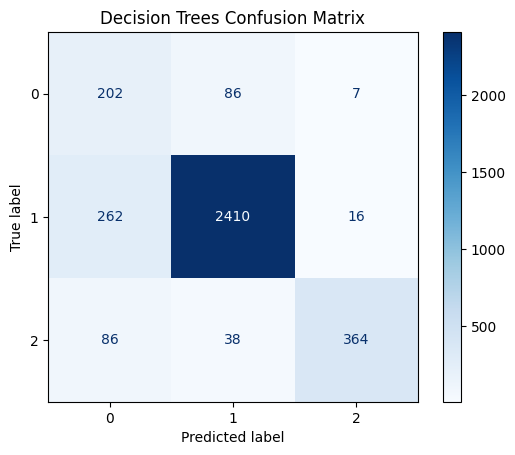

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_test_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test Set Accuracy: **{test_accuracy:.4f}**")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, zero_division=0))

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Decision Trees Confusion Matrix")
plt.show()